# SOM

In [1]:
import pandas as pd
file = "Smart_City_index_headers.csv"
data = pd.read_csv( file)

data.head()
data.shape

(102, 11)

## Scale the dataframe

In [2]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Columns that you want to scale
columns_to_scale = [
    'Smart_Mobility', 'Smart_Environment', 'Smart_Government', 
    'Smart_Economy', 'Smart_People', 'Smart_Living', 'SmartCity_Index', 
    'SmartCity_Index_relative_Edmonton'
]

# Apply the scaler to the dataset
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

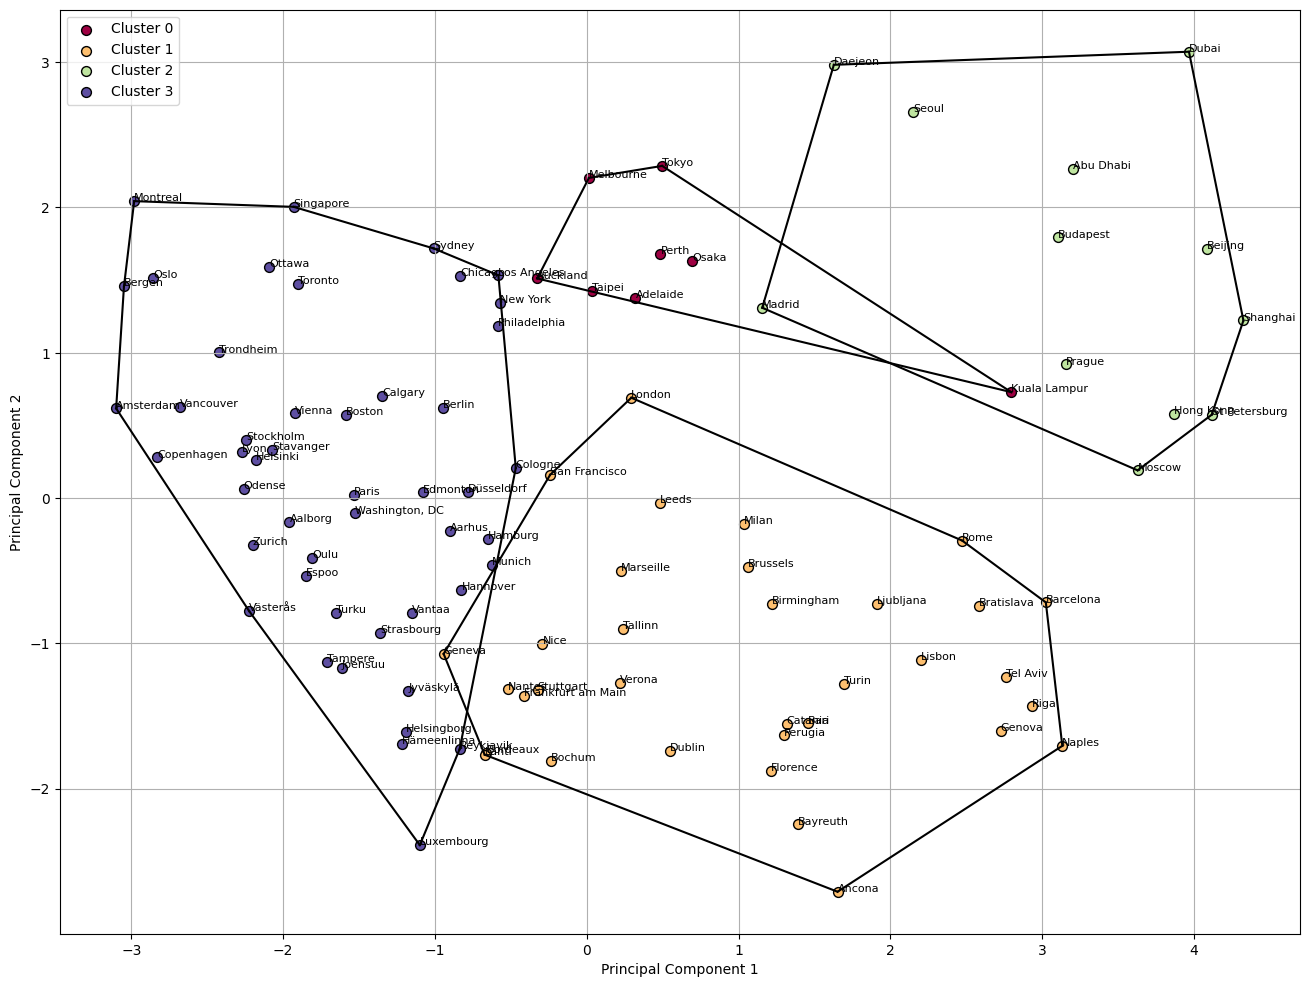

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from minisom import MiniSom

# Assuming 'data' and 'columns_to_check' are defined
columns_to_check = [
    'Smart_Mobility', 'Smart_Environment', 'Smart_Government',
    'Smart_Economy', 'Smart_People', 'Smart_Living', 'SmartCity_Index',
    'SmartCity_Index_relative_Edmonton'
]

# Extract the raw data
data_raw = data[columns_to_check].values

# Initialize and train the SOM
som_size = (10, 10)  # SOM grid size
som = MiniSom(som_size[0], som_size[1], data_raw.shape[1], sigma=0.38, learning_rate=0.5)
som.random_weights_init(data_raw)
som.train_random(data_raw, 1000)

# Extract the weight vectors from the SOM
weight_vectors = som.get_weights().reshape(-1, data_raw.shape[1])

# Apply K-means clustering to the weight vectors
kmeans = KMeans(n_clusters=4)  # Adjust the number of clusters as needed
kmeans.fit(weight_vectors)
cluster_labels = kmeans.predict(weight_vectors)

# Map the SOM BMUs to the K-means clusters
winner_coordinates = np.array([som.winner(x) for x in data_raw]).T
cluster_index = np.ravel_multi_index(winner_coordinates, som_size)
data['Cluster'] = [cluster_labels[i] for i in cluster_index]

# Perform PCA for visualization purposes
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data[columns_to_check])

# Plotting the clusters with convex hulls
plt.figure(figsize=(16, 12))
unique_labels = np.unique(data['Cluster'])
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (data['Cluster'] == k)
    
    xy = data_pca[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], edgecolors='k', s=50, label=f'Cluster {k}')
    
    if len(xy) > 2:  # Convex hull can only be formed if there are more than 2 points
        hull = ConvexHull(xy)
        for simplex in hull.simplices:
            plt.plot(xy[simplex, 0], xy[simplex, 1], 'k-')

    for i in range(len(xy)):
        plt.text(xy[i, 0], xy[i, 1], data[class_member_mask].iloc[i]['City'], fontsize=8)

# plt.title('SOM Clustering with Convex Hulls')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.savefig('som.pdf', dpi=1200)  # dpi=1200 for high resolution


In [5]:
# Assuming 'data' is your original dataset that contains the 'City' column

# Extract the city names from the data
city_names = data['City'].values

# Create a DataFrame to easily manage the cities and clusters
df_cities = pd.DataFrame({
    'City': city_names,
    'Cluster': data['Cluster']  # Assuming 'Cluster' contains the SOM cluster labels
})

# Print cities for each cluster
for cluster in np.unique(data['Cluster']):
    print(f"Cluster {cluster}:")
    cluster_cities = df_cities[df_cities['Cluster'] == cluster]['City'].values
    print(", ".join(cluster_cities))
    print("\n")


Cluster 0:
Taipei, Adelaide, Melbourne, Tokyo, Perth, Auckland, Osaka, Kuala Lampur


Cluster 1:
Geneva, Frankfurt am Main, San Francisco, Bochum, Stuttgart, London, Bordeaux, Milan, Nantes, Brussels, Marseille, Leeds, Lahti, Dublin, Verona, Nice, Tallinn, Catania, Bayreuth, Turin, Florence, Birmingham, Bari, Bratislava, Ljubljana, Perugia, Tel Aviv, Barcelona, Ancona, Lisbon, Rome, Genova, Naples, Riga


Cluster 2:
Madrid, Daejeon, Abu Dhabi, Seoul, Dubai, Budapest, Hong Kong, Prague, Shanghai, Moscow, Beijing, St Petersburg


Cluster 3:
Oslo, Bergen, Amsterdam, Copenhagen, Stockholm, Montreal, Vienna, Odense, Singapore, Boston, Zurich, Trondheim, Västerås, Aalborg, Ottawa, Washington, DC, Stavanger, Los Angeles, Helsinki, Vancouver, Berlin, Toronto, New York, Chicago, Düsseldorf, Reykjavik, Lyon, Helsingborg, Munich, Philadelphia, Hamburg, Luxembourg, Aarhus, Turku, Espoo, Paris, Hannover, Strasbourg, Joensuu, Sydney, Oulu, Cologne, Hämeenlinna, Tampere, Jyväskylä, Vantaa, Calgary, E

# Model performance

In [6]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Assuming `data` contains the feature data and `data['Cluster']` contains the cluster labels

# Calculate the Silhouette Score
sil_score = silhouette_score(data[columns_to_check], data['Cluster'])
print(f'Silhouette Score: {sil_score}')

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(data[columns_to_check], data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Calculate the Calinski-Harabasz Index
ch_index = calinski_harabasz_score(data[columns_to_check], data['Cluster'])
print(f'Calinski-Harabasz Index: {ch_index}')

Silhouette Score: 0.2560543215231972
Davies-Bouldin Index: 1.1880997555145145
Calinski-Harabasz Index: 34.507849370607424
